In [16]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.contrib.layers as ly
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import os, re
import pickle
import pymysql
import pymongo
import json
import requests
import time, datetime

In [17]:
def g1(x):
    x = str(x)
    date = x[:4] + x[5:7] + x[8:10]
    time = int(x[11:13])
    if time == 0:
        result = 0
    else:
        result = load_list[date][time] - load_list[date][time-1]
    return result

def g2(x):
    x = str(x)
    date = x[:4] + x[5:7] + x[8:10]
    time = int(x[11:13])
    if time == 23:
        result = 0
    else:
        result = load_list[date][time+1] - load_list[date][time]
    return result

def normalize(x, x_min, x_max):
    x = (2*x - x_max - x_min) / (x_max - x_min + 1e-5)
    return x

def re_normalize(x, x_min, x_max):
    x = ((x_max - x_min + 1e-5) * x + x_max + x_min) / 2
    return x

def wind_speed_encoding(x):
    if x == 'AUTO':
        return 1
    elif x == 'LOW':
        return 2
    elif x == 'MEDIUM':
        return 3
    else:
        return 4

def mode_encoding(x):
    if x == 'AUTO':
        return 1
    elif x == 'COLD':
        return 2
    elif x == 'DEHUMI':
        return 3
    elif x == 'VENT':
        return 4
    else:
        return 5   
    
def power_state_encoding(x):
    if x == 'ON':
        return 1
    else:
        return 0

def plot_loss(list_train_loss, list_test_loss):
    plt.figure(figsize=(16,6))
    plt.plot(list_train_loss, label='train loss')
    plt.plot(list_test_loss, label='test loss')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)    
    plt.xlabel('Epoch', fontsize=25)
    plt.ylabel('Loss', fontsize=25)
    plt.legend(loc='best', fontsize=20)
    plt.show()
    
def plot_acc(list_train_acc, list_test_acc):
    plt.figure(figsize=(16,6))
    plt.plot(list_train_acc, label='train acc')
    plt.plot(list_test_acc, label='test acc')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)    
    plt.xlabel('Epoch', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.legend(loc='best', fontsize=20)
    plt.show()
        
def plot_result(time, y_true, y_pred, label):    
    for i in range(len(time) // 20):
        plt.figure(figsize=(16,4))
        plt.plot(time[i*20:(i+1)*20], y_true[i*20:(i+1)*20], 'ro-', label='ground truth')
        plt.plot(time[i*20:(i+1)*20], y_pred[i*20:(i+1)*20], 'bo-', label=label)
        plt.xticks(rotation=30, fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('Time', fontsize=25)
        plt.ylabel('Temperature', fontsize=25)
        plt.legend(loc='best', fontsize=20)
        plt.show()        

def plot_temperature(time, temp):
    plt.figure(figsize=(16,6))
    plt.plot(time, temp, 'ro-', label='Temperature indoor')
    plt.xticks(rotation=30, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Temperature', fontsize=25)
    plt.legend(loc='best', fontsize=20)
    plt.show()

In [18]:
def init_model_params():
    model_params = {'Network': {'Layers': []}}
    return model_params

def conv_layer_json(model_params, layer, w, b, strides):
    x = layer.get_shape().as_list()[2]
    y = layer.get_shape().as_list()[1]
    z = layer.get_shape().as_list()[3]
    kernal_size = w.shape[0]
    layer_json = {'LayerType': 'conv', 'InputSize': {'X': x, 'Y': y, 'Z': z},\
                  'Parameters': {'Stride': strides, 'KernelSize': kernal_size}, 'Weights': [], 'Biases': {}}
    w_data = w.transpose((3,2,0,1)).tolist()
    for data in w_data:
        weights_json = {'TDSize': {'X': kernal_size, 'Y': kernal_size, 'Z': z}, 'Data': data}
        layer_json['Weights'].append(weights_json)
    b_data = [b.reshape(-1,1).tolist()]
    biases_json = {'TDSize': {'X': 1, 'Y': len(w), 'Z':1}, 'Data': b_data}
    layer_json['Biases'] = biases_json
    model_params['Network']['Layers'].append(layer_json)
    return model_params

def gap_layer_json(model_params, layer):
    x = layer.get_shape().as_list()[2]
    y = layer.get_shape().as_list()[1]
    z = layer.get_shape().as_list()[3]
    layer_json = {'LayerType': 'gap', 'InputSize': {'X': x, 'Y': y, 'Z': z}}
    model_params['Network']['Layers'].append(layer_json)
    return model_params

def fc_layer_json(model_params, layer, w, b):
    if len(layer.get_shape()) == 2:
        x = layer.get_shape().as_list()[1]
        y = 1
        z = 1
    elif len(layer.get_shape()) == 4:
        x = layer.get_shape().as_list()[2]
        y = layer.get_shape().as_list()[1]
        z = layer.get_shape().as_list()[3]
    else:
        print('error')
    layer_json = {'LayerType': 'fc', 'InputSize': {'X': x, 'Y': y, 'Z': z},\
                  'OutputSize': {'X': w.shape[1], 'Y': 1, 'Z': 1}, 'Weights': [], 'Biases': {}}
    w_data = [w.transpose(1,0).tolist()]
    weights_json = {'TDSize': {'X': w.shape[0], 'Y': w.shape[1], 'Z': 1}, 'Data': w_data}
    layer_json['Weights'].append(weights_json)
    b_data = [b.reshape(-1,1).tolist()]
    biases_json = {'TDSize': {'X': 1, 'Y': b.shape[0], 'Z':1}, 'Data': b_data}
    layer_json['Biases'] = biases_json
    model_params['Network']['Layers'].append(layer_json)    
    return model_params

def relu_layer_json(model_params, layer):
    x = layer.get_shape().as_list()[1]
    y = 1
    z = 1    
    layer_json = {'LayerType': 'relu', 'InputSize': {'X': x, 'Y': y, 'Z': z}}
    model_params['Network']['Layers'].append(layer_json)    
    return model_params

In [19]:
mongo = pymongo.MongoClient(
    host = '10.10.3.153',            
    port = 27017
)
mongo_db = mongo['thermocontrol']

In [20]:
city, endpointid, did = 'zhuhai', '3009043075069384925', '780f7759bf850000050001001edfcc8e' # 格力花园四楼
# city, endpointid, did = 'hangzhou', '3008193246025911637', '780f7727e49c0000050001009a2f4d14' # 康总
# city, endpointid, did = 'hangzhou', '3009059270064407738', '780f7727e53a0000050001007134ba30' # 姚总
# city, endpointid, did = 'hangzhou', '3008097348623416618', '780f7727e53a000005000100d627f84e' # 茶水间
# city, endpointid, did = 'hangzhou', '3008248669026814986', '780f7727e53a000005000100e59f80ec' # 刘总

In [21]:
col = mongo_db['controldata']
ret = col.find({'endpointid':endpointid}).sort([('date',-1)]).limit(100)
raw_data = []
for i in ret:
    raw_data += i['data']

df = pd.DataFrame(raw_data)[['time','dt','power_state','temp_set','mode','wind_speed',\
                             'temp_in','temp_in_start','temp_out','humid_in','humid_in_start',\
                             'power_state_previous','temp_set_previous','mode_previous','wind_speed_previous']]
df['time'] = pd.to_datetime(df.time)
df = df.sort_values(['time']).reset_index(drop=True)
df = df[df.temp_in != -1].reset_index(drop=True)
df['temp_in_delta'] = df.temp_in - df.temp_in_start
df['temp_in_out'] = df.temp_in_start - df.temp_out
df['temp_set_in'] = df.temp_set - df.temp_in_start
df['temp_set_out'] = df.temp_set - df.temp_out
df = df[df['power_state'] == 'ON'].reset_index(drop=True)
df['power_state'] = df.power_state.apply(power_state_encoding)
df['power_state_previous'] = df.power_state_previous.apply(power_state_encoding)
df['mode'] = df['mode'].apply(mode_encoding)
df['mode_previous'] = df.mode_previous.apply(mode_encoding)
df['wind_speed'] = df['wind_speed'].apply(wind_speed_encoding)
df.loc[df[df.power_state==0].index, ['temp_set','mode','wind_speed','temp_set_in']] = 0
df.loc[df[df.power_state_previous==0].index, ['temp_set_previous','mode_previous','wind_speed_previous']] = 0
df.dropna(inplace=True)
df['dt'] = df.dt.apply(lambda x: x / 60)
df = df[(df.dt <= 35) & (df.dt != 0)].reset_index(drop=True)

In [22]:
df = df[df.time <= '2019-08-12']
# df.loc[:,'wind_speed'] = 1

In [23]:
df1 = df.iloc[:int(0.99*df.shape[0]),:] # for train and test
df2 = df.iloc[int(0.99*df.shape[0]):,:] # for valid

In [24]:
features = ['temp_in_out', 'temp_set_in', 'temp_in_start', 'dt', 'mode', 'wind_speed', 'power_state'] # 变频
# features += ['power_state_previous', 'mode_previous'] # 变频+上一次操作
x = df1[features].values
y = df1[['temp_in_delta']].values
z = df1[['temp_in_start']].values
shuffled_indexes = np.random.permutation(x.shape[0])
x = x[shuffled_indexes]
y = y[shuffled_indexes]
z = z[shuffled_indexes]
x_min, x_max = x.min(axis=0).reshape(1,x.shape[1]), x.max(axis=0).reshape(1,x.shape[1])
y_min, y_max = y.min(), y.max()
x = normalize(x, x_min, x_max)
y = normalize(y, y_min, y_max)

In [25]:
percent = 0.7
x_train = x[:int(percent*df1.shape[0])]
x_test = x[int(percent*df1.shape[0]):]
y_train = y[:int(percent*df1.shape[0])]
y_test = y[int(percent*df1.shape[0]):]
z_train = z[:int(percent*df1.shape[0])]
z_test = z[int(percent*df1.shape[0]):]
time_train = df1.time[:int(percent*df1.shape[0])]
time_test = df1.time[int(percent*df1.shape[0]):]

In [26]:
n_epochs = 1000
initial_learning_rate = 0.001
n_classes = 1
n_input = x_train.shape[1]
n_examples = x_train.shape[0]
batch_size = 8
n_batches_per_epoch = int(n_examples / batch_size)
n_hidden_1 = 8
n_hidden_2 = 8
n_hidden_3 = 8
n_hidden_4 = 8
n_hidden_5 = 8

In [27]:
# 定义图
graph = tf.Graph()
with graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, n_input])
    targets = tf.placeholder(tf.float32, [None, n_classes])

# 正常学习
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'w3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'w4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
        'w5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
        'w6': tf.Variable(tf.random_normal([n_hidden_5, n_classes])),
    }
    
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4])),
        'b5': tf.Variable(tf.random_normal([n_hidden_5])),
        'b6': tf.Variable(tf.random_normal([n_classes])),
    }
    
# 迁移学习    
#     weights = {
#         'w1': tf.Variable(w1.astype(np.float32)),
#         'w2': tf.Variable(w2.astype(np.float32)),
#         'w3': tf.Variable(w3.astype(np.float32)),
#         'w4': tf.Variable(w4.astype(np.float32)),
#         'w5': tf.Variable(w5.astype(np.float32)),
#         'w6': tf.Variable(w6.astype(np.float32)),
#     }
    
#     biases = {
#         'b1': tf.Variable(b1.astype(np.float32)),
#         'b2': tf.Variable(b2.astype(np.float32)),
#         'b3': tf.Variable(b3.astype(np.float32)),
#         'b4': tf.Variable(b4.astype(np.float32)),
#         'b5': tf.Variable(b5.astype(np.float32)),
#         'b6': tf.Variable(b6.astype(np.float32)),
#     }
    
        
    def DNN(inputs, weights, biases):
        x = tf.add(tf.matmul(inputs, weights['w1']), biases['b1'])
        x = tf.nn.relu(x)
        x = tf.add(tf.matmul(x, weights['w2']), biases['b2'])
        x = tf.nn.relu(x)
        x = tf.add(tf.matmul(x, weights['w3']), biases['b3'])
        x = tf.nn.relu(x)
        x = tf.add(tf.matmul(x, weights['w4']), biases['b4'])
        x = tf.nn.relu(x)
        x = tf.add(tf.matmul(x, weights['w5']), biases['b5'])
        x = tf.nn.relu(x)
        x = tf.add(tf.matmul(x, weights['w6']), biases['b6'])
        return x

    pred = DNN(inputs, weights, biases)
    loss = tf.reduce_mean(tf.square(pred - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(loss)
    init = tf.global_variables_initializer()

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [28]:
inputs

NameError: name 'inputs' is not defined

In [1]:
# 定义会话
sess = tf.Session(graph=graph)
sess.run(init)
list_train_loss = []
list_test_loss = []
list_train_acc = []
list_test_acc = []
test_loss_temp = 1e10
test_acc_temp = 0
train_acc_temp = 0
for curr_epoch in range(n_epochs):
    train_loss = 0
    for batch in range(n_batches_per_epoch):
        indexes = [i % n_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
        batch_x_train = x_train[indexes]
        batch_y_train = y_train[indexes]

        feed_batch={inputs: batch_x_train, targets: batch_y_train}
        sess.run(optimizer, feed_batch)

    feed_train={inputs: x_train, targets: y_train}
    train_loss, y_train_pred = sess.run([loss, pred], feed_train)
    list_train_loss.append(train_loss)

    feed_test={inputs: x_test, targets: y_test}
    test_loss, y_test_pred = sess.run([loss, pred], feed_test)
    list_test_loss.append(test_loss)

    y_train_real = re_normalize(y_train, y_min, y_max) + z_train
    y_test_real = re_normalize(y_test, y_min, y_max) + z_test
    y_train_pred = re_normalize(y_train_pred, y_min, y_max) + z_train
    y_test_pred = re_normalize(y_test_pred, y_min, y_max) + z_test
    
    train_acc = ((abs(y_train_real - y_train_pred) < 0.2).all(axis=1)).sum() / len(y_train_real)
    list_train_acc.append(train_acc)
    test_acc = ((abs(y_test_real - y_test_pred) < 0.2).all(axis=1)).sum() / len(y_test_real)
    list_test_acc.append(test_acc)

    if test_loss < test_loss_temp:
        test_loss_temp = test_loss
        test_acc_temp = test_acc
        train_acc_temp = train_acc
        w1, b1 = sess.run([weights['w1'], biases['b1']])
        w2, b2 = sess.run([weights['w2'], biases['b2']])
        w3, b3 = sess.run([weights['w3'], biases['b3']])
        w4, b4 = sess.run([weights['w4'], biases['b4']])
        w5, b5 = sess.run([weights['w5'], biases['b5']])
        w6, b6 = sess.run([weights['w6'], biases['b6']])

    if (curr_epoch+1) % 100 == 0 or (curr_epoch+1) == 1:
        log = 'Epoch {}/{}: train_loss = {:.4f}, test_loss = {:.4f}, train_acc = {:.3f}, test_acc = {:.3f}'
        print(log.format(curr_epoch+1, n_epochs, train_loss, test_loss, train_acc, test_acc))
        
print('The minimal test loss is {:.3f} with the train accuracy {:.3f} test accuracy {:.3f}'\
      .format(test_loss_temp, train_acc_temp, test_acc_temp))
plot_acc(list_train_acc, list_test_acc)

NameError: name 'tf' is not defined

In [ ]:
# 所有时间的图
x1 = df[features].values
z1 = df[['temp_in_start']].values
x1 = normalize(x1, x_min, x_max)
x1 = x1.dot(w1) + b1
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w2) + b2
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w3) + b3
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w4) + b4
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w5) + b5
x1 = (abs(x1) + x1) / 2
y_pred = x1.dot(w6) + b6
y_pred = re_normalize(y_pred, y_min, y_max) + z1

plt.figure(figsize=(16,8))
plt.plot(df.time, df.temp_in, 'ro-', label='Truth Curve')
plt.plot(df.time[:len(df1)], y_pred[:len(df1)], 'bo-', label='Train and Test Curve')
plt.plot(df.time[len(df1):], y_pred[len(df1):], 'go-', label='Valid Curve')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Temperature', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

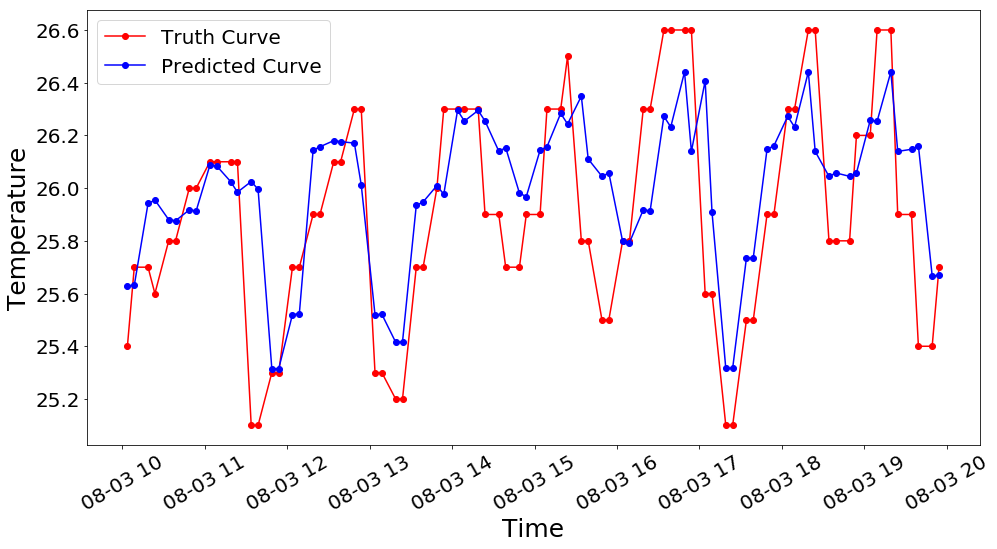

In [592]:
# 指定时间的图
time_left = '2019-08-3 10'
time_right = '2019-08-3 20'
query = (df.time > time_left) & (df.time < time_right)

x1 = df[query][features].values
z1 = df[query][['temp_in_start']].values
x1 = normalize(x1, x_min, x_max)
x1 = x1.dot(w1) + b1
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w2) + b2
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w3) + b3
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w4) + b4
x1 = (abs(x1) + x1) / 2
x1 = x1.dot(w5) + b5
x1 = (abs(x1) + x1) / 2
y_pred = x1.dot(w6) + b6
y_pred = re_normalize(y_pred, y_min, y_max) + z1

plt.figure(figsize=(16,8))
plt.plot(df[query].time, df[query].temp_in, 'ro-', label='Truth Curve')
plt.plot(df[query].time, y_pred[:len(df1)], 'bo-', label='Predicted Curve')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Temperature', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

# 测试

In [593]:
power_state_str_to_int = {
    'ON': 1,
    'OFF': 0
}
mode_str_to_int = {
    'NAN': 0,
    'COLD': 2,
    'VENT': 4,
    'HEAT': 5
}
wind_speed_str_to_int = {
    'AUTO': 1,
    'LOW': 2,
    'MEDIUM': 3,
    'HIGH': 4
}

In [597]:
temp_in_start, temp_out = 26.3, 22
temp_in_out = temp_in_start - temp_out
print(temp_in_start, temp_out, temp_in_out)

26.3 22 4.300000000000001


In [604]:
step = 1
deltat = 30
ret_arr = {}
temp_target = 26
for power_state in ['ON']:
    for mode in ['COLD', 'HEAT', 'VENT']:
        if temp_target > temp_out and mode == 'COLD':
            continue
        if temp_target < temp_out and mode == 'HEAT':
            continue        
        for wind_speed in ['AUTO','LOW','MEDIUM','HIGH']:
            for temp_set in range(16,31):
                y_pred_list = []
                for i in range(deltat,deltat+1,step):
                    temp_set_in = temp_set - temp_in_start
                    if power_state == 'OFF':
                        x1 = np.array([[temp_in_out, 0, temp_in_start, \
                                        i, 0, 0, 0]])
                    elif power_state == 'ON' and mode == 'VENT':
                        x1 = np.array([[temp_in_out, 0, temp_in_start, \
                                        i, mode_str_to_int[mode], wind_speed_str_to_int[wind_speed], \
                                        power_state_str_to_int[power_state]]])
                    else:
                        x1 = np.array([[temp_in_out, temp_set_in, temp_in_start, \
                                        i, mode_str_to_int[mode], wind_speed_str_to_int[wind_speed], \
                                        power_state_str_to_int[power_state]]])
                    z1 = np.array([[temp_in_start]])
                    x1 = normalize(x1, x_min, x_max)
                    x1 = x1.dot(w1) + b1
                    x1 = (abs(x1) + x1) / 2
                    x1 = x1.dot(w2) + b2
                    x1 = (abs(x1) + x1) / 2
                    x1 = x1.dot(w3) + b3
                    x1 = (abs(x1) + x1) / 2
                    x1 = x1.dot(w4) + b4
                    x1 = (abs(x1) + x1) / 2
                    x1 = x1.dot(w5) + b5         
                    x1 = (abs(x1) + x1) / 2
                    y_pred = x1.dot(w6) + b6
                    y_pred = re_normalize(y_pred, y_min, y_max) + z1
                    y_pred_list.append(round(y_pred[0][0],3))
                if power_state == 'OFF':
                    if power_state_ == 'OFF':
                        k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + power_state_ + '_' + 'OFF'
                    else:
                        k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + 'OFF'
                elif power_state == 'ON' and mode == 'VENT':
                    if temp_set == int(temp_in_start):
                        if power_state_ == 'OFF':
                            k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + str(temp_set) + '_' + mode + '_' + wind_speed
                        else:
                            k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + str(temp_set) + '_' + mode + '_' + wind_speed
                    else:
                        continue
                else:
                    if power_state_ == 'OFF':
                        k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + str(temp_set) + '_' + mode + '_' + wind_speed
                    else:
                        k = str(round(10*temp_in_start)) + '_' + str(temp_out) + '_' + str(temp_set) + '_' + mode + '_' + wind_speed
                ret_arr.update({k:np.array(y_pred_list)})

In [605]:
# 深度学习
ret_val = {}
for k,v in ret_arr.items():
    key = str(round(10*temp_target)) + '_' + k
    ret_val.update({key:abs(v - temp_target).sum() / len(v)})
ret_val = pd.Series(ret_val)
print(ret_val.sort_values()[:10],'\n')

260_263_22_27_HEAT_AUTO    0.088
260_263_22_21_HEAT_AUTO    0.149
260_263_22_22_HEAT_AUTO    0.181
260_263_22_19_HEAT_LOW     0.236
260_263_22_18_HEAT_LOW     0.274
260_263_22_26_HEAT_AUTO    0.284
260_263_22_17_HEAT_LOW     0.309
260_263_22_16_HEAT_LOW     0.344
260_263_22_16_HEAT_AUTO    0.381
260_263_22_28_HEAT_AUTO    0.460
dtype: float64 



# 保存模型

In [505]:
fc1 = tf.add(tf.matmul(inputs, weights['w1']), biases['b1'])
relu1 = tf.nn.relu(fc1)
fc2 = tf.add(tf.matmul(relu1, weights['w2']), biases['b2'])
relu2 = tf.nn.relu(fc2)
fc3 = tf.add(tf.matmul(relu2, weights['w3']), biases['b3'])
relu3 = tf.nn.relu(fc3)
fc4 = tf.add(tf.matmul(relu3, weights['w4']), biases['b4'])
relu4 = tf.nn.relu(fc4)                
fc5 = tf.add(tf.matmul(relu4, weights['w5']), biases['b5'])    
relu5 = tf.nn.relu(fc5)
pred = tf.add(tf.matmul(relu5, weights['w6']), biases['b6'])

model_params = init_model_params()
model_params = fc_layer_json(model_params, inputs, w1, b1)
model_params = relu_layer_json(model_params, fc1)
model_params = fc_layer_json(model_params, fc1, w2, b2)
model_params = relu_layer_json(model_params, fc2)
model_params = fc_layer_json(model_params, fc2, w3, b3)
model_params = relu_layer_json(model_params, fc3)
model_params = fc_layer_json(model_params, fc3, w4, b4)
model_params = relu_layer_json(model_params, fc4)
model_params = fc_layer_json(model_params, fc4, w5, b5)
model_params = relu_layer_json(model_params, fc1)
model_params = fc_layer_json(model_params, fc5, w6, b6)

In [506]:
scale = {'scale': {'xmin':x_min.tolist()[0], 'xmax':x_max.tolist()[0], 'ymin':[y_min], 'ymax':[y_max]}}
transfermodel = scale.copy()
transfermodel.update({'modelparams': model_params})

In [507]:
with open('../control/transfermodel.txt', 'w') as f:
    content = json.dumps(transfermodel)
    f.write(content)